In [14]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras

RANDOM_SEED = 42

# Especificación de cada ruta

In [15]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'

# Configuración del número de clasificaciones

In [16]:
NUM_CLASSES = 3

# Carga de datos de entrenamiento

In [17]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [18]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Construcción del modelo

In [23]:
model = keras.models.Sequential([
    keras.layers.Input((21 * 2, )),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [24]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_4 (Dropout)         (None, 42)                0         
                                                                 
 dense_6 (Dense)             (None, 20)                860       
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                                 
 dense_7 (Dense)             (None, 10)                210       
                                                                 
 dense_8 (Dense)             (None, 3)                 33        
                                                                 
Total params: 1,103
Trainable params: 1,103
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Callback de punto de control del modelo
cp_callback = keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback para detención temprana
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [26]:
# Compilación del modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenamiento del modelo

In [27]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [28]:
# Entrenar el modelo y guardar la historia
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/27 [>.............................] - ETA: 9s - loss: 1.1488 - accuracy: 0.3828
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.keras
27/27 [==============================] - 1s 9ms/step - loss: 1.0880 - accuracy: 0.3962 - val_loss: 1.0015 - val_accuracy: 0.5193
Epoch 2/1000
 1/27 [>.............................] - ETA: 0s - loss: 1.0341 - accuracy: 0.4297
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.keras
27/27 [==============================] - 0s 3ms/step - loss: 1.0339 - accuracy: 0.4291 - val_loss: 0.9542 - val_accuracy: 0.5472
Epoch 3/1000
 1/27 [>.............................] - ETA: 0s - loss: 1.0225 - accuracy: 0.4844
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.keras
27/27 [==============================] - 0s 3ms/step - loss: 1.0082 - accuracy: 0.4567 - val_loss: 0.9111 - val_accuracy: 0.6164
Epoch 4/1000
 1/27 [>.............................] - ETA: 0s - loss: 0.9868 - accuracy: 0.507

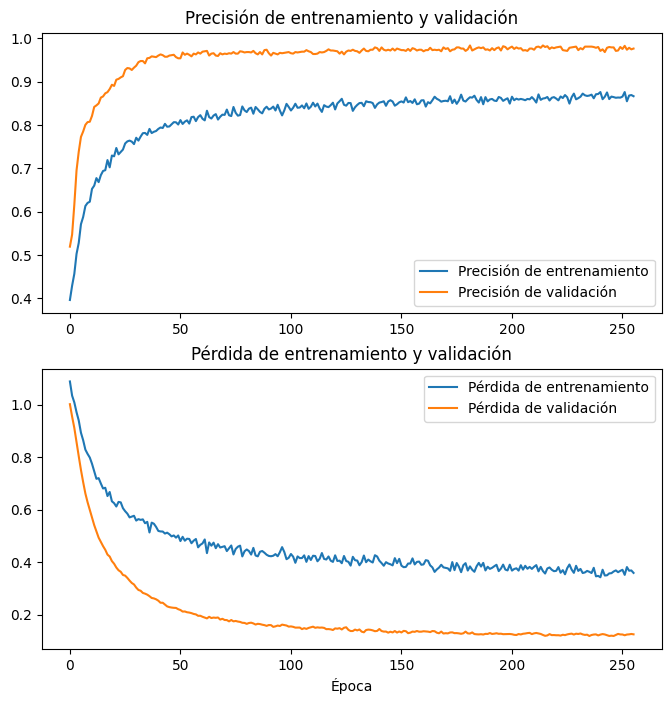

In [29]:
import matplotlib.pyplot as plt

# Graficar la precisión
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.legend(loc='lower right')
plt.title('Precisión de entrenamiento y validación')

# Graficar la pérdida
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.legend(loc='upper right')
plt.title('Pérdida de entrenamiento y validación')
plt.xlabel('Época')
plt.show()

In [30]:
# Evaluación del modelo
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

9/9 [==============================] - 0s 875us/step - loss: 0.1258 - accuracy: 0.9766


In [31]:
# Carga del modelo guardado
model = tf.keras.models.load_model(model_save_path)

In [32]:
# Prueba de inferencia
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 72ms/step
[0.8774843  0.08419741 0.03831826]
0


# Matriz de confusión

35/35 [==============================] - 0s 823us/step


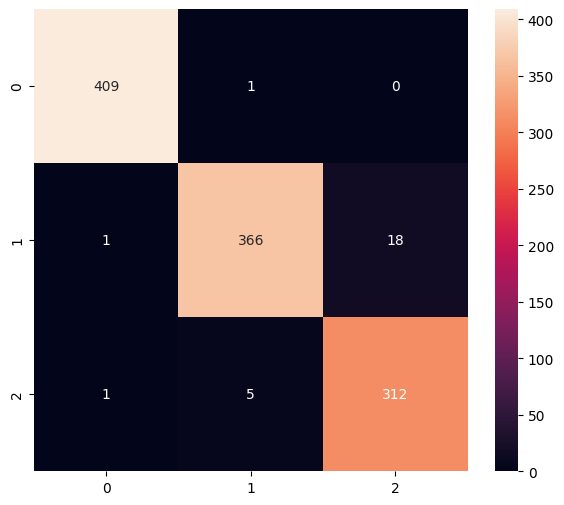

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       410
           1       0.98      0.95      0.97       385
           2       0.95      0.98      0.96       318

    accuracy                           0.98      1113
   macro avg       0.97      0.98      0.98      1113
weighted avg       0.98      0.98      0.98      1113



In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Conversión a modelo para Tensorflow-Lite

In [16]:
# Guardar como modelo exclusivamente para inferencia
model.save(model_save_path, include_optimizer=False)

In [17]:
# Modelo de conversión (cuantificación)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

#open(tflite_save_path, 'wb').write(tflite_quantized_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\sihit\AppData\Local\Temp\tmpy2l6ipxu\assets


6224

# Prueba de inferencia

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [19]:
# Obtener tensores de entrada y salida
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# Realizar inferencia
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

Wall time: 0 ns


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.7729778  0.16973573 0.05728643]
0
